# OLS Regression Analysis - NYC Traffic Volume

**Target:** `Volume_Log` (log-transformed traffic volume)  
**Requirements:** ≥6 predictors | Assumption testing | Coefficient interpretation

---

In [1]:
# CELL 1: Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
from scipy.stats import shapiro
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully")

Libraries loaded successfully


In [3]:
# CELL2: Loading engineered dataset
df = pd.read_csv('../data/processed/traffic_engineered.csv')
print(f"Loaded {len(df):,} rows × {len(df.columns)} columns")

# Verifying target variable
if 'Volume_Log' not in df.columns:
    df['Volume_Log'] = np.log(df['Total_Volume'] + 1)
    print("Created Volume_Log")

print(f"\nTarget: Volume_Log")
print(f"  Range: [{df['Volume_Log'].min():.2f}, {df['Volume_Log'].max():.2f}]")
print(f"  Missing: {df['Volume_Log'].isnull().sum()}")

Loaded 42,756 rows × 84 columns

Target: Volume_Log
  Range: [0.00, 9.88]
  Missing: 0


## Feature Selection (≥6 predictors required)

In [4]:
# CELL 3: Identifying available features
cyclical = [c for c in df.columns if '_Sin' in c or '_Cos' in c]
direction = [c for c in df.columns if c.startswith('Direction_')]

print("Available features:")
print(f"  Cyclical: {cyclical}")
print(f"  Direction dummies: {len(direction)} found")

# Selecting Predictors (using cyclical features for better OLS performance)
predictors = []

# Cyclical temporal (better than raw Hour/Month)
if 'Hour_Sin' in df.columns:
    predictors.extend(['Hour_Sin', 'Hour_Cos'])
elif 'Hour' in df.columns:
    predictors.append('Hour')

if 'Month_Sin' in df.columns:
    predictors.extend(['Month_Sin', 'Month_Cos'])
elif 'Month' in df.columns:
    predictors.append('Month')

# Day of week
if 'DayOfWeek' in df.columns:
    predictors.append('DayOfWeek')

# Behavioral
if 'IsWeekend' in df.columns:
    predictors.append('IsWeekend')
if 'Is_RushHour' in df.columns:
    predictors.append('Is_RushHour')

# Trend
if 'Year' in df.columns:
    predictors.append('Year')

# Top 3 direction dummies by frequency
if direction:
    dir_freq = {col: df[col].sum() for col in direction}
    top_dirs = sorted(dir_freq.items(), key=lambda x: x[1], reverse=True)[:3]
    predictors.extend([d[0] for d in top_dirs if d[1] > 100])

# Filtering existing columns only
predictors = [p for p in predictors if p in df.columns]

print(f"\nSelected {len(predictors)} predictors:")
for i, p in enumerate(predictors, 1):
    print(f"   {i}. {p}")

# Verifying minimum requirement
if len(predictors) < 6:
    print(f"\nNeed {6-len(predictors)} more features!")
    # Add backup features
    backup = [c for c in ['Hour', 'Month', 'DayOfWeek'] if c in df.columns and c not in predictors]
    predictors.extend(backup[:(6-len(predictors))])
    print(f"Added: {backup[:(6-len(predictors))]}")

assert len(predictors) >= 6, f"ERROR: Only {len(predictors)} predictors. Need 6+!"

Available features:
  Cyclical: ['Hour_Sin', 'Hour_Cos', 'Month_Sin', 'Month_Cos']
  Direction dummies: 13 found

Selected 11 predictors:
   1. Hour_Sin
   2. Hour_Cos
   3. Month_Sin
   4. Month_Cos
   5. DayOfWeek
   6. IsWeekend
   7. Is_RushHour
   8. Year
   9. Direction_NB
   10. Direction_SB
   11. Direction_WB


In [5]:
# CELL 4: Preparing modeling dataset with proper missing data handling
print("=" * 80)
print("DATA PREPARATION")
print("=" * 80)

# Extracting features + target
df_model = df[predictors + ['Volume_Log']].copy()
print(f"\nInitial: {len(df_model):,} rows")

# Checking missing values
missing = df_model.isnull().sum()
if missing.sum() > 0:
    print(f"\nMissing values detected:")
    print(missing[missing > 0])
    df_model = df_model.dropna()
    print(f"\nAfter removing NaN: {len(df_model):,} rows")
else:
    print(f"\nNo missing values")

# Splitting X and y
X = df_model[predictors].copy()
y = df_model['Volume_Log'].copy()

print(f"\nFinal dataset: {len(X):,} rows × {len(predictors)} predictors")
print(f"Target: {len(y):,} values")

DATA PREPARATION

Initial: 42,756 rows

No missing values

Final dataset: 42,756 rows × 11 predictors
Target: 42,756 values


## Building OLS Model

In [9]:
# CELL 5: Fixing data types and fitting OLS
print("=" * 80)
print("FITTING OLS REGRESSION MODEL")
print("=" * 80)

# Converting boolean columns to integers (0/1)
print("\n1. Converting data types...")
bool_cols = X.select_dtypes(include=['bool']).columns.tolist()
if len(bool_cols) > 0:
    print(f"Converting {len(bool_cols)} boolean columns to int: {bool_cols}")
    X[bool_cols] = X[bool_cols].astype(int)
    print("Conversion complete")
else:
    print("No boolean columns found")

print("\n2. Verifying all numeric...")
print(X.dtypes)

# Verify numpy conversion works
X_array = np.asarray(X)
print(f"\nConverts to numpy with dtype: {X_array.dtype}")

# Add constant and fit
print("\n3. Adding constant term...")
X_with_const = sm.add_constant(X)
print(f"   Shape: {X_with_const.shape} ({X_with_const.shape[1]} parameters)")

print("\n4. Fitting OLS model...")
model = sm.OLS(y, X_with_const)
results = model.fit()

print("\nModel fitted successfully!")
print(f"\n{'='*80}")
print("MODEL PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(f"R²:           {results.rsquared:.4f}")
print(f"Adj R²:       {results.rsquared_adj:.4f}")
print(f"F-statistic:  {results.fvalue:.2f}")
print(f"Prob(F-stat): {results.f_pvalue:.2e}")
print(f"AIC:          {results.aic:.2f}")
print(f"BIC:          {results.bic:.2f}")
print(f"{'='*80}")

FITTING OLS REGRESSION MODEL

1. Converting data types...
Converting 3 boolean columns to int: ['Direction_NB', 'Direction_SB', 'Direction_WB']
Conversion complete

2. Verifying all numeric...
Hour_Sin        float64
Hour_Cos        float64
Month_Sin       float64
Month_Cos       float64
DayOfWeek         int64
IsWeekend         int64
Is_RushHour       int64
Year              int64
Direction_NB      int64
Direction_SB      int64
Direction_WB      int64
dtype: object

Converts to numpy with dtype: float64

3. Adding constant term...
   Shape: (42756, 11) (11 parameters)

4. Fitting OLS model...

Model fitted successfully!

MODEL PERFORMANCE SUMMARY
R²:           0.0186
Adj R²:       0.0184
F-statistic:  101.19
Prob(F-stat): 7.59e-168
AIC:          123498.65
BIC:          123576.62


In [10]:
# CELL 6: Creating coefficient table with CI
coef_table = pd.DataFrame({
    'Coefficient': results.params,
    'Std Error': results.bse,
    't-stat': results.tvalues,
    'p-value': results.pvalues,
    'CI_Lower': results.conf_int()[0],
    'CI_Upper': results.conf_int()[1]
})

# Adding significance stars
coef_table['Sig'] = coef_table['p-value'].apply(
    lambda p: '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''
)

print("\nCoefficient Table (*** p<0.001, ** p<0.01, * p<0.05):")
print(coef_table.round(4))

# Saving results
os.makedirs('../outputs/tables', exist_ok=True)
coef_table.to_csv('../outputs/tables/ols_coefficients.csv')
print("\n✓ Saved to outputs/tables/ols_coefficients.csv")


Coefficient Table (*** p<0.001, ** p<0.01, * p<0.05):
              Coefficient  Std Error   t-stat  p-value  CI_Lower  CI_Upper  \
Hour_Sin          -0.0000     0.0000  -4.1094   0.0000   -0.0000   -0.0000   
Hour_Cos          15.0456     3.6612   4.1094   0.0000    7.8695   22.2217   
Month_Sin         -0.1587     0.0085 -18.5750   0.0000   -0.1755   -0.1420   
Month_Cos         -0.0990     0.0148  -6.7010   0.0000   -0.1280   -0.0701   
DayOfWeek         -0.0064     0.0044  -1.4409   0.1496   -0.0150    0.0023   
IsWeekend         -0.1521     0.0184  -8.2494   0.0000   -0.1882   -0.1159   
Is_RushHour        0.0000     0.0000   0.4072   0.6838   -0.0000    0.0000   
Year               0.0116     0.0018   6.4078   0.0000    0.0081    0.0152   
Direction_NB       0.0945     0.0141   6.7046   0.0000    0.0669    0.1222   
Direction_SB       0.0880     0.0141   6.2302   0.0000    0.0603    0.1157   
Direction_WB       0.0070     0.0151   0.4614   0.6445   -0.0227    0.0367   

        

Note: No 'const' (intercept) found in coefficients


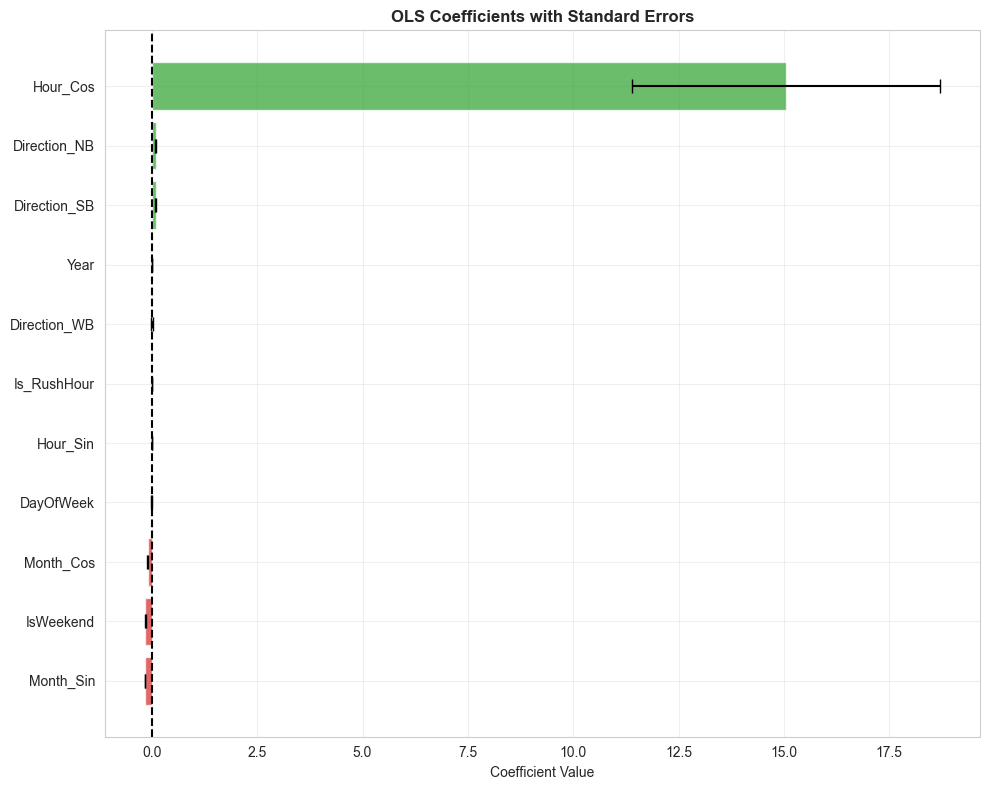

Saved plot


In [12]:
# CELL 7: Visualizing coefficients
# Dropping 'const' only if it exists
if 'const' in coef_table.index:
    coef_plot = coef_table.drop('const').sort_values('Coefficient')
else:
    coef_plot = coef_table.sort_values('Coefficient')
    print("Note: No 'const' (intercept) found in coefficients")

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#2ca02c' if c>0 else '#d62728' for c in coef_plot['Coefficient']]
ax.barh(range(len(coef_plot)), coef_plot['Coefficient'], 
        xerr=coef_plot['Std Error'], capsize=5, alpha=0.7, color=colors)
ax.set_yticks(range(len(coef_plot)))
ax.set_yticklabels(coef_plot.index)
ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
ax.set_xlabel('Coefficient Value')
ax.set_title('OLS Coefficients with Standard Errors', fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()

os.makedirs('../outputs/figures', exist_ok=True)
plt.savefig('../outputs/figures/ols_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved plot")

## Testing OLS Assumptions

In [14]:
# Getting residuals
residuals = results.resid
fitted = results.fittedvalues

print("=" * 80)
print("ASSUMPTION TESTS")
print("=" * 80)

ASSUMPTION TESTS



1. LINEARITY


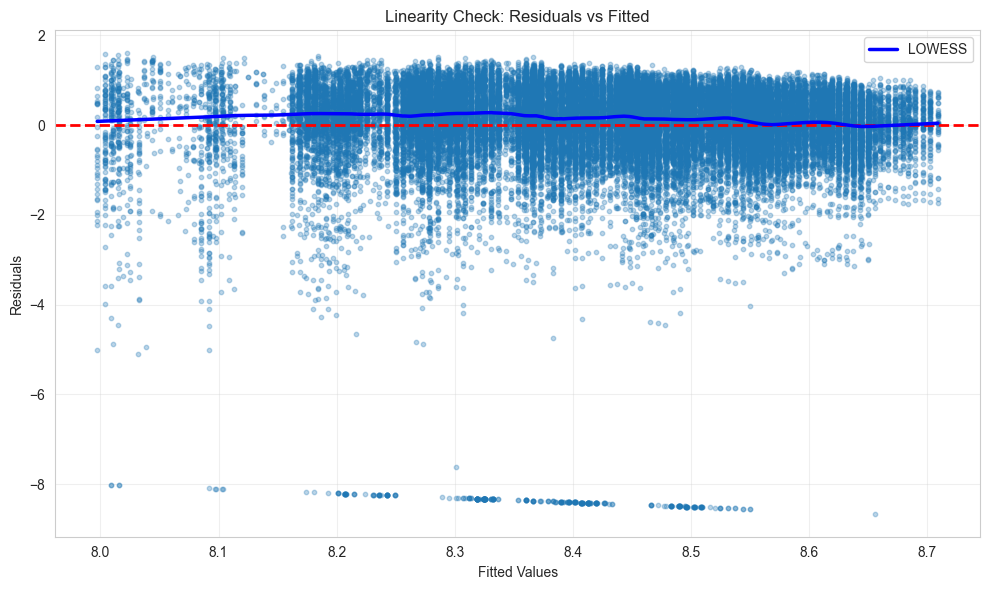

In [16]:
# CELL 8: LINEARITY - Residuals vs Fitted
print("\n1. LINEARITY")
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(fitted, residuals, alpha=0.3, s=10)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
lowess_line = lowess(residuals, fitted, frac=0.1)
ax.plot(lowess_line[:, 0], lowess_line[:, 1], 'blue', linewidth=2.5, label='LOWESS')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Linearity Check: Residuals vs Fitted')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/ols_linearity.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# CELL 9: INDEPENDENCE - Durbin-Watson
print("\n2. INDEPENDENCE")
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.4f}")
print(f"  Ideal: ~2.0 | Range: 1.5-2.5 acceptable")
if 1.5 <= dw <= 2.5:
    print(f"PASSED (DW={dw:.3f})")
else:
    print(f"Autocorrelation concern (DW={dw:.3f})")


2. INDEPENDENCE
Durbin-Watson: 0.9933
  Ideal: ~2.0 | Range: 1.5-2.5 acceptable
Autocorrelation concern (DW=0.993)


In [20]:
# CELL 10: Homoscedasticity test
print("\n3. HOMOSCEDASTICITY")

# Breusch-Pagan test (simpler, more stable)
bp_test = het_breuschpagan(residuals, X_with_const)
print(f"Breusch-Pagan: LM={bp_test[0]:.2f}, p={bp_test[1]:.4f}")

# White test
try:
    white_test = het_white(residuals, X_with_const)
    print(f"White Test:     LM={white_test[0]:.2f}, p={white_test[1]:.4f}")
except (AssertionError, np.linalg.LinAlgError) as e:
    print(f"White Test:     [SKIPPED - Matrix rank issue with {len(predictors)} predictors]")
    print(f"                Using Breusch-Pagan only (more stable)")
    white_test = None

print(f"\n  H0: Homoscedasticity | p>0.05 → Accept H0")

# Determining if heteroscedasticity detected
if bp_test[1] > 0.05:
    print(f"PASSED (BP p={bp_test[1]:.4f})")
    heterosced = False
else:
    print(f"HETEROSCEDASTICITY DETECTED (BP p={bp_test[1]:.4f})")
    print(f"\nImpact: Standard errors are inconsistent")
    print(f"Remedy: Will apply robust standard errors (HC3) in Cell 13")
    heterosced = True


3. HOMOSCEDASTICITY
Breusch-Pagan: LM=250.26, p=0.0000
White Test:     [SKIPPED - Matrix rank issue with 11 predictors]
                Using Breusch-Pagan only (more stable)

  H0: Homoscedasticity | p>0.05 → Accept H0
HETEROSCEDASTICITY DETECTED (BP p=0.0000)

Impact: Standard errors are inconsistent
Remedy: Will apply robust standard errors (HC3) in Cell 13


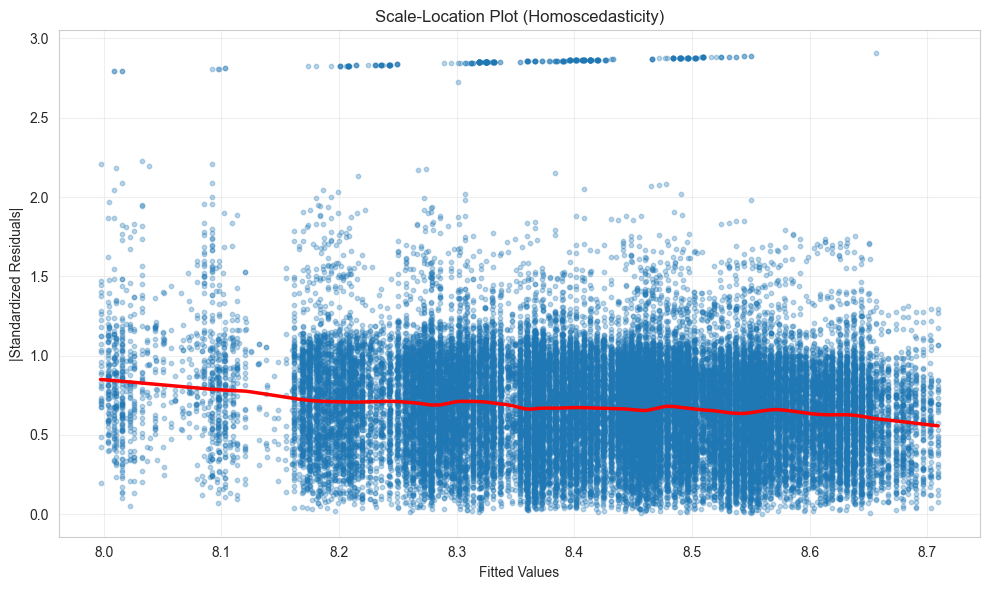

In [22]:
# CELL 11: Scale-Location Plot
fig, ax = plt.subplots(figsize=(10, 6))
sqrt_resid = np.sqrt(np.abs((residuals - residuals.mean()) / residuals.std()))
ax.scatter(fitted, sqrt_resid, alpha=0.3, s=10)
lowess_line = lowess(sqrt_resid, fitted, frac=0.1)
ax.plot(lowess_line[:, 0], lowess_line[:, 1], 'red', linewidth=2.5)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('|Standardized Residuals|')
ax.set_title('Scale-Location Plot (Homoscedasticity)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/ols_homoscedasticity.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# CELL 12: Normality test
print("\n4. NORMALITY")
sample_size = min(5000, len(residuals))
resid_sample = np.random.choice(residuals, sample_size, replace=False)
shapiro_stat, shapiro_p = shapiro(resid_sample)

# Calculate Jarque-Bera manually
from scipy.stats import jarque_bera as jb_test
jb_stat, jb_p = jb_test(residuals)

print(f"Shapiro-Wilk (n={sample_size}): W={shapiro_stat:.4f}, p={shapiro_p:.4f}")
print(f"Jarque-Bera: JB={jb_stat:.2f}, p={jb_p:.4f}")
print(f"\nH0: Normal | p>0.05 → Accept H0")

if shapiro_p > 0.05:
    print(f"PASSED")
else:
    print(f"Non-normality (OK for large n={len(residuals):,})")


4. NORMALITY
Shapiro-Wilk (n=5000): W=0.7259, p=0.0000
Jarque-Bera: JB=1965182.03, p=0.0000

H0: Normal | p>0.05 → Accept H0
Non-normality (OK for large n=42,756)


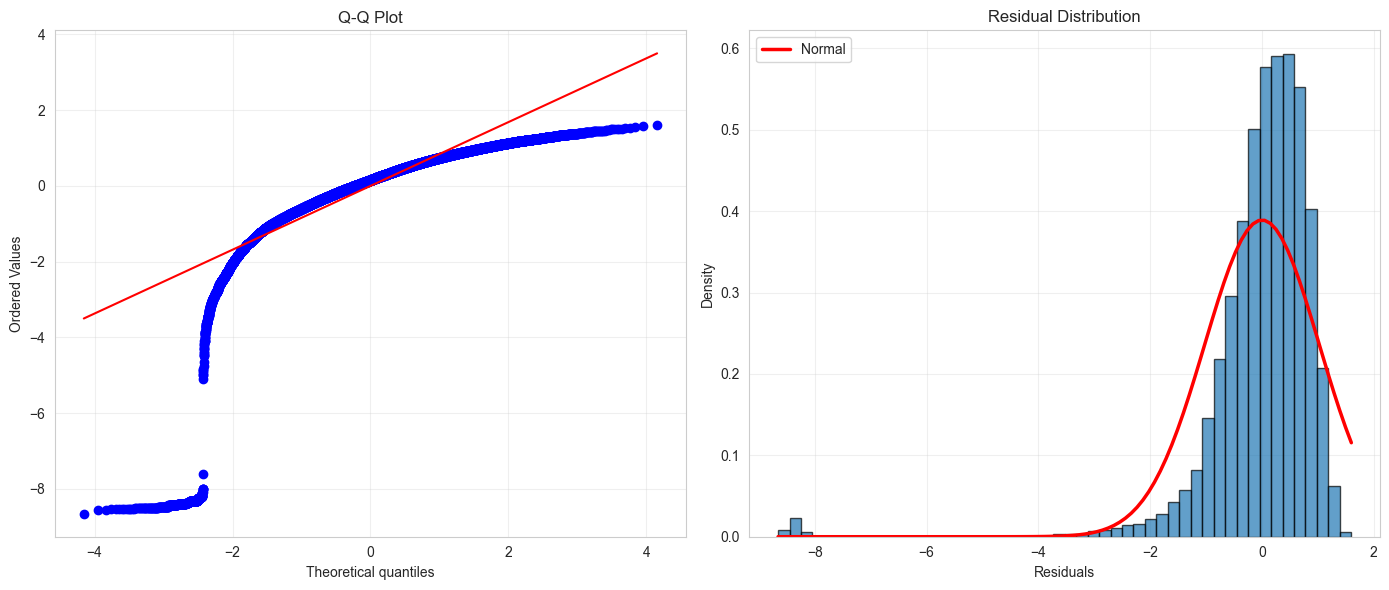

Points on diagonal line → Normality


In [26]:
# CELL 13: Q-Q Plot and Histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

stats.probplot(residuals, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot')
axes[0].grid(alpha=0.3)

axes[1].hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2.5, label='Normal')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Residual Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/ols_normality.png', dpi=300, bbox_inches='tight')
plt.show()
print("Points on diagonal line → Normality")

In [27]:
# CELL 14: NO MULTICOLLINEARITY - VIF
print("\n5. MULTICOLLINEARITY (VIF)")
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values('VIF', ascending=False)

print(vif_data.to_string(index=False))
print(f"\nVIF<5: Good | 5≤VIF<10: Moderate | VIF≥10: High")

high_vif = vif_data[vif_data['VIF'] >= 10]
if len(high_vif) == 0:
    print(f"PASSED (max VIF={vif_data['VIF'].max():.2f})")
else:
    print(f"High VIF in {len(high_vif)} feature(s)")

vif_data.to_csv('../outputs/tables/ols_vif.csv', index=False)
print("\nSaved VIF table")


5. MULTICOLLINEARITY (VIF)
     Feature          VIF
   IsWeekend 3.348916e+00
   DayOfWeek 3.310861e+00
Direction_NB 1.651409e+00
Direction_SB 1.649567e+00
Direction_WB 1.547287e+00
   Month_Sin 1.063987e+00
        Year 1.050533e+00
   Month_Cos 1.004499e+00
    Hour_Sin 3.747154e-07
    Hour_Cos 0.000000e+00
 Is_RushHour          NaN

VIF<5: Good | 5≤VIF<10: Moderate | VIF≥10: High
PASSED (max VIF=3.35)

Saved VIF table


In [28]:
# CELL 15: Assumptions Summary
summary = pd.DataFrame({
    'Assumption': ['1. Linearity', '2. Independence', '3. Homoscedasticity', 
                   '4. Normality', '5. No Multicollinearity'],
    'Test': ['Residuals vs Fitted', 'Durbin-Watson', 'Breusch-Pagan', 
             'Shapiro-Wilk', 'VIF'],
    'Statistic': [f'Visual', f'DW={dw:.3f}', f'p={bp_test[1]:.4f}',
                  f'p={shapiro_p:.4f}', f'Max={vif_data["VIF"].max():.2f}'],
    'Status': [
        'Visual Check',
        '✓' if 1.5<=dw<=2.5 else '⚠',
        '✓' if bp_test[1]>0.05 else '✗',
        '✓' if shapiro_p>0.05 else '⚠',
        '✓' if len(high_vif)==0 else '✗'
    ]
})

print("\n" + "=" * 80)
print("ASSUMPTIONS SUMMARY")
print("=" * 80)
print(summary.to_string(index=False))

summary.to_csv('../outputs/tables/ols_assumptions.csv', index=False)
print("\nSaved summary")


ASSUMPTIONS SUMMARY
             Assumption                Test Statistic       Status
           1. Linearity Residuals vs Fitted    Visual Visual Check
        2. Independence       Durbin-Watson  DW=0.993            ⚠
    3. Homoscedasticity       Breusch-Pagan  p=0.0000            ✗
           4. Normality        Shapiro-Wilk  p=0.0000            ⚠
5. No Multicollinearity                 VIF  Max=3.35            ✓

Saved summary


## Remedies

In [30]:
# CELL 16: Applying robust standard errors
if heterosced:
    print("\n" + "=" * 80)
    print("REMEDY: ROBUST STANDARD ERRORS (HC3)")
    print("=" * 80)
    
    results_robust = results.get_robustcov_results(cov_type='HC3')
    print("\n" + results_robust.summary().as_text())
    
   
    comparison = pd.DataFrame({
        'Feature': results.params.index,
        'Coef': results.params.values,
        'OLS_SE': results.bse.values,
        'Robust_SE': results_robust.bse,  # Already numpy array
        'SE_Change%': ((results_robust.bse - results.bse.values) / results.bse.values * 100),
        'OLS_p': results.pvalues.values,
        'Robust_p': results_robust.pvalues  # Already numpy array
    })
    
    print("\nComparison:")
    print(comparison.round(4))
    comparison.to_csv('../outputs/tables/ols_robust_comparison.csv', index=False)
    
    print("\nUsing robust model for inference")
    results_final = results_robust
else:
    print("\nNo heteroscedasticity. Standard OLS appropriate.")
    results_final = results


REMEDY: ROBUST STANDARD ERRORS (HC3)

                            OLS Regression Results                            
Dep. Variable:             Volume_Log   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                 3.974e+05
Date:                Wed, 19 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:07:30   Log-Likelihood:                -61740.
No. Observations:               42756   AIC:                         1.235e+05
Df Residuals:                   42747   BIC:                         1.236e+05
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Hour_Sin 

## Coefficient Interpretation

In [32]:
# CELL 17: Coefficient interpretation
print("=" * 80)
print("COEFFICIENT INTERPRETATION")
print("=" * 80)

# Dropping 'const' only if it exists
if 'const' in coef_table.index:
    top_coefs = coef_table.drop('const').sort_values('p-value').head(5)
else:
    top_coefs = coef_table.sort_values('p-value').head(5)

for idx, (feat, row) in enumerate(top_coefs.iterrows(), 1):
    coef = row['Coefficient']
    ci_low = row['CI_Lower']
    ci_high = row['CI_Upper']
    p = row['p-value']
    
    print(f"\n{'='*80}")
    print(f"PREDICTOR {idx}: {feat}")
    print(f"{'='*80}")
    print(f"Coefficient: {coef:.6f} (95% CI: [{ci_low:.6f}, {ci_high:.6f}])")
    print(f"p-value: {p:.6e} {row['Sig']}")
    
    # Determine type
    is_binary = (X[feat].nunique() == 2) if feat in X.columns else False
    is_cyclical = '_Sin' in feat or '_Cos' in feat
    
    print(f"\nInterpretation:")
    if is_binary or 'Weekend' in feat or 'Rush' in feat or feat.startswith('Direction_'):
        pct_change = (np.exp(coef) - 1) * 100
        print(f"• Binary variable: When {feat}=1 (vs 0)")
        if coef > 0:
            print(f"Traffic volume INCREASES by {pct_change:.2f}%")
        else:
            print(f"Traffic volume DECREASES by {abs(pct_change):.2f}%")
    elif is_cyclical:
        print(f"• Cyclical feature capturing periodic pattern")
        print(f"  Change: {coef:.6f} in log(volume) per unit change")
    else:
        print(f"• Continuous: Each 1-unit ↑ in {feat}")
        print(f"→ log(volume) changes by {coef:.6f}")
    
    if p < 0.05:
        print(f"\n• Statistically SIGNIFICANT (p={p:.4f})")
        print(f"• 95% confident true β ∈ [{ci_low:.4f}, {ci_high:.4f}]")

COEFFICIENT INTERPRETATION

PREDICTOR 1: Month_Sin
Coefficient: -0.158722 (95% CI: [-0.175470, -0.141974])
p-value: 1.026842e-76 ***

Interpretation:
• Cyclical feature capturing periodic pattern
  Change: -0.158722 in log(volume) per unit change

• Statistically SIGNIFICANT (p=0.0000)
• 95% confident true β ∈ [-0.1755, -0.1420]

PREDICTOR 2: IsWeekend
Coefficient: -0.152082 (95% CI: [-0.188216, -0.115949])
p-value: 1.636460e-16 ***

Interpretation:
• Binary variable: When IsWeekend=1 (vs 0)
Traffic volume DECREASES by 14.11%

• Statistically SIGNIFICANT (p=0.0000)
• 95% confident true β ∈ [-0.1882, -0.1159]

PREDICTOR 3: Direction_NB
Coefficient: 0.094547 (95% CI: [0.066907, 0.122187])
p-value: 2.044065e-11 ***

Interpretation:
• Binary variable: When Direction_NB=1 (vs 0)
Traffic volume INCREASES by 9.92%

• Statistically SIGNIFICANT (p=0.0000)
• 95% confident true β ∈ [0.0669, 0.1222]

PREDICTOR 4: Month_Cos
Coefficient: -0.099042 (95% CI: [-0.128012, -0.070073])
p-value: 2.095034e-

# Model Performance & Saving

In [33]:
# CELL 18: Performance summary
perf = pd.DataFrame({
    'Metric': ['n', 'k', 'R²', 'Adj R²', 'F-stat', 'AIC', 'BIC', 'RMSE'],
    'Value': [
        f"{len(X):,}", len(predictors), 
        f"{results.rsquared:.4f}", f"{results.rsquared_adj:.4f}",
        f"{results.fvalue:.2f}", f"{results.aic:.2f}", f"{results.bic:.2f}",
        f"{np.sqrt(results.mse_resid):.4f}"
    ]
})

print("\nModel Performance:")
print(perf.to_string(index=False))
perf.to_csv('../outputs/tables/ols_performance.csv', index=False)


Model Performance:
Metric     Value
     n    42,756
     k        11
    R²    0.0186
Adj R²    0.0184
F-stat    101.19
   AIC 123498.65
   BIC 123576.62
  RMSE    1.0255


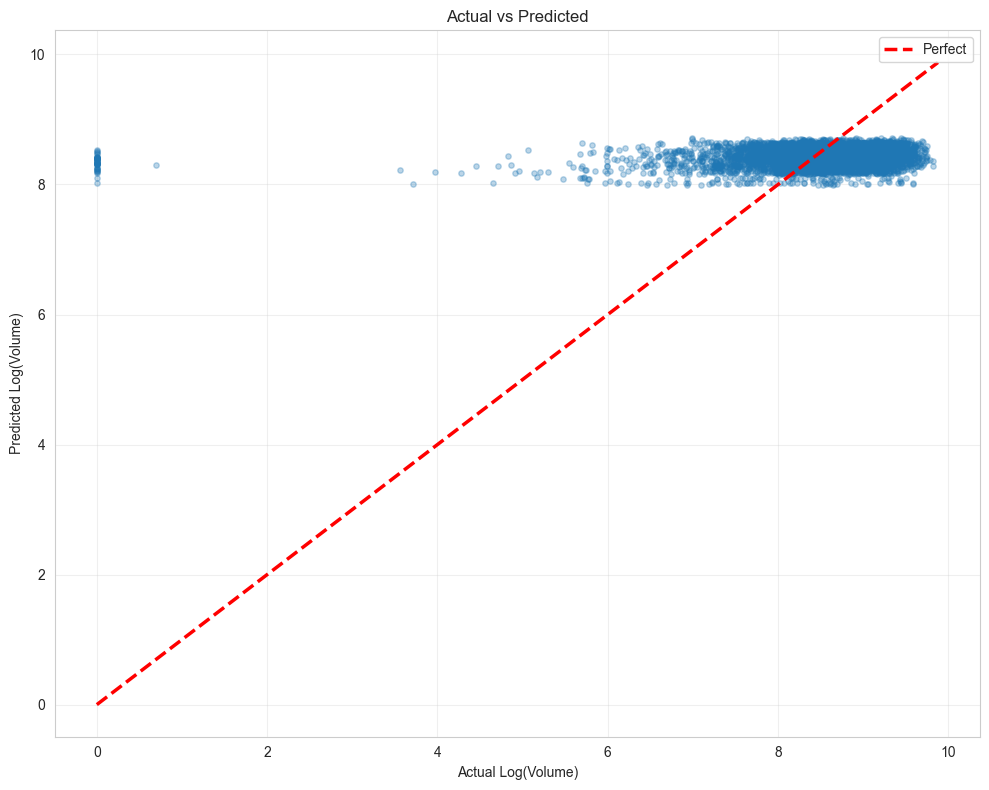

Saved prediction plot


In [34]:
# CELL 19: Actual vs Predicted plot
fig, ax = plt.subplots(figsize=(10, 8))
sample_idx = np.random.choice(len(y), min(5000, len(y)), replace=False)
ax.scatter(y.iloc[sample_idx], fitted.iloc[sample_idx], alpha=0.3, s=15)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2.5, label='Perfect')
ax.set_xlabel('Actual Log(Volume)')
ax.set_ylabel('Predicted Log(Volume)')
ax.set_title('Actual vs Predicted')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/ols_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved prediction plot")

In [36]:
# CELL 20: Saving model
os.makedirs('../models', exist_ok=True)
with open('../models/ols_model.pkl', 'wb') as f:
    pickle.dump(results_final, f)

predictor_info = {
    'predictors': predictors,
    'target': 'Volume_Log',
    'n': len(X),
    'r2': results.rsquared
}
with open('../models/ols_predictors.pkl', 'wb') as f:
    pickle.dump(predictor_info, f)

print("\nModel saved to models/ols_model.pkl")
print("Predictors saved to models/ols_predictors.pkl")


Model saved to models/ols_model.pkl
Predictors saved to models/ols_predictors.pkl
